In [15]:
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE
from collections import Counter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import umap
import h5py
from tqdm import tqdm
import sys
import os

ImportError: Matplotlib requires numpy>=1.23; you have 1.22.3

In [14]:
!conda install -c conda-forge --force-reinstall "numpy<2" "matplotlib" "pandas" --update-deps -y

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: / Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: / done
done

## Package Plan ##

  environment location: /home/acomajuncosa/miniconda3/envs/camt

  added / updated specs:
    - matplotlib
    - numpy[version='<2']
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.15.3          |       hb03c661_0         571 KB  conda-forge
    aom-3.9.1                  |       hac33072_0         2.6 MB  conda-forge
    cffi-2.0.0                 |  py310he7384ee_1         239 KB  conda-forge
    dbus-1.16.2                |       h24cb091_1         437 KB  conda-forge
    expat-2.7.3                |       hecca717_0         141 KB  conda-forge
    fribidi-1.0.16             |       hb03c661_0          60 KB  conda-forge
    lcms2-2.17 

In [3]:
# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import DATAPATH, CONFIGPATH

# Load pathogen info
# pathogen_code = sys.argv[1]
pathogen_code = 'mtuberculosis'
df = pd.read_csv(os.path.join(CONFIGPATH, 'pathogens.csv'))
row = df.loc[df["code"].eq(pathogen_code)]
if row.empty: 
    raise SystemExit(f"Unknown code: {pathogen_code}")
pathogen = row.iloc[0]["pathogen"]

# Create output directory
OUTPUT = os.path.join(root, "..", "output")

In [4]:
def load_ecfp_all(h5_path):
    """Load all ECFP (Morgan count) fingerprints.

    Parameters
    ----------
    h5_path : str
        Path to the HDF5 file containing datasets "SMILES" and "X_morgan".

    Returns
    -------
    dict[str, np.ndarray]
        Mapping {chembl_id: fingerprint (np.int8, shape (nBits,))}.
    """
    with h5py.File(h5_path, "r") as f:
        meta = f["SMILES"][:, 3].astype(str)
        fps  = f["X_morgan"][:]  # Load ALL

    return {cid: fp for cid, fp in zip(meta, fps)}

# Loading Morgan fingerprints
PATH_TO_ECFPs = os.path.join(DATAPATH, "chembl_processed", "ChEMBL_ECFPs.h5")
ecfps = load_ecfp_all(PATH_TO_ECFPs)

In [ ]:
# def fit_umap_reference(ecfp_dict, n_ref=10_000, seed=42):
#     """
#     Sample n_ref compounds, fit UMAP, and persist:
#       - fitted reducer
#       - reference ids
#       - reference embedding
#     """

#     # Sample n_ref ids
#     ids_all = np.array(list(ecfp_dict.keys()))
#     rng = np.random.default_rng(seed)
#     ref_ids = rng.choice(ids_all, size=n_ref, replace=False)

#     # Build matrix
#     X_ref = np.stack([ecfp_dict[i] for i in ref_ids], axis=0)

#     # Binarize
#     X_ref = (X_ref > 0).astype(np.uint8)

#     # UMAP prefers float32 for speed/memory
#     X_ref = X_ref.astype(np.float32, copy=False)

#     reducer = umap.UMAP(
#         n_neighbors=30,
#         min_dist=0.15,
#         n_components=2,
#         metric="jaccard",
#         random_state=seed,
#         verbose=True,
#     )

#     emb_ref = reducer.fit_transform(X_ref)

#     # os.makedirs(outdir, exist_ok=True)
#     # joblib.dump(reducer, os.path.join(outdir, "umap_reducer.joblib"))
#     # np.save(os.path.join(outdir, "umap_ref_ids.npy"), ref_ids)
#     # np.save(os.path.join(outdir, "umap_ref_emb.npy"), emb_ref)

#     return reducer, ref_ids, emb_ref

# reducer, ref_ids, ref_emb = fit_umap_reference(ecfps, n_ref=10_000, seed=42)

import numpy as np

def fit_mc_tsne_with_bg(ecfp_dict, ids, n_bg=25_000, seed=42, perplexity=30, pca_dim=50, n_jobs=-1, verbose=1):
    """
    Fit multicore t-SNE on [ids] + [random background from ecfp_dict].

    Parameters
    ----------
    ecfp_dict : dict
        {id: fingerprint array}. All fingerprints must share the same length.
    ids : sequence
        Compound IDs (must be keys in ecfp_dict). These are placed first in the embedding.
    n_bg : int
        Number of random background IDs sampled from ecfp_dict (excluding ids).
    seed : int
        RNG seed (also passed to t-SNE).
    perplexity : float
        t-SNE perplexity (must be < n_samples).
    pca_dim : int or None
        If set, PCA-reduce to this dimension before t-SNE (recommended for speed).
    n_jobs : int
        Threads for MulticoreTSNE (-1 = all cores).
    verbose : int
        Verbosity for MulticoreTSNE.

    Returns
    -------
    all_ids : np.ndarray
        IDs aligned with rows of emb; first len(ids) are the input ids.
    emb : np.ndarray
        2D embedding of shape (len(ids)+n_bg, 2).
    """

    ids = np.array(list(ids))
    rng = np.random.default_rng(seed)

    pool = np.array([k for k in ecfp_dict.keys() if k not in set(ids.tolist())])
    bg_ids = rng.choice(pool, size=min(n_bg, len(pool)), replace=False)
    all_ids = np.concatenate([ids, bg_ids])

    X = np.stack([ecfp_dict[i] for i in all_ids]).astype(np.float32, copy=False)
    X = (X > 0).astype(np.float32, copy=False)

    if pca_dim is not None:
        from sklearn.decomposition import PCA
        d = min(pca_dim, X.shape[1], X.shape[0] - 1)
        X = PCA(n_components=d, random_state=seed, svd_solver="randomized").fit_transform(X)

    n = X.shape[0]
    if perplexity >= n:
        perplexity = max(5.0, (n - 1) / 3)

    emb = MulticoreTSNE(
        n_components=2, perplexity=perplexity, random_state=seed, n_jobs=n_jobs, verbose=verbose
    ).fit_transform(X)

    return all_ids, emb


    return tsne, ref_ids, emb_ref





/home/acomajuncosa/miniconda3/envs/camt/lib/python3.10/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='jaccard',
     min_dist=0.15, n_neighbors=30, random_state=42, verbose=True)
Construct fuzzy simplicial set
Fri Jan 30 12:17:05 2026 Finding Nearest Neighbors
Fri Jan 30 12:17:05 2026 Building RP forest with 10 trees
Fri Jan 30 12:17:10 2026 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Fri Jan 30 12:17:19 2026 Finished Nearest Neighbor Search
Fri Jan 30 12:17:21 2026 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Jan 30 12:17:33 2026 Finished embedding


In [6]:
# Number of compounds, activities and assays
raw = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "mtuberculosis_ChEMBL_raw_data.csv.gz"))
activities_raw = len(raw)
compounds_raw = len(set(raw['compound_chembl_id']))
cleaned = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "mtuberculosis_ChEMBL_cleaned_data.csv.gz"))
activities_cleaned = len(cleaned)
compounds_cleaned = len(set(cleaned['compound_chembl_id']))
assays_raw = len(pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_raw.csv")))
assays_cleaned = len(pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv")))
del raw, cleaned

In [7]:
# Assay type
df = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv"))
assay_type = Counter(df['assay_type'])
assay_type = [assay_type['F'] / sum(assay_type.values()), (assay_type['F'] + assay_type['B']) / sum(assay_type.values()), 1][::-1]
target_type = Counter(df['target_type'])
target_type = [target_type['ORGANISM'] / sum(target_type.values()), (target_type['ORGANISM'] + target_type['SINGLE PROTEIN']) / sum(target_type.values()), 1][::-1]
assay_organism = Counter(df['assay_organism'])
assay_organism = [assay_organism[pathogen_code] / sum(assay_organism.values()), 1]

In [8]:
# Load reference compounds from pathogen
reference_compounds = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "compound_counts.csv.gz"))[:1_000]['compound_chembl_id']
X_pathogen = np.array([ecfps[i] for i in reference_compounds])
X_pathogen = (X_pathogen > 0).astype(np.uint8)
X_pathogen = reducer.transform(X_pathogen)

Fri Jan 30 12:17:54 2026 Worst tree score: 0.42500000
Fri Jan 30 12:17:54 2026 Mean tree score: 0.44299000
Fri Jan 30 12:17:54 2026 Best tree score: 0.46760000
Fri Jan 30 12:17:56 2026 Forward diversification reduced edges from 300000 to 116309
Fri Jan 30 12:17:58 2026 Reverse diversification reduced edges from 116309 to 116199
Fri Jan 30 12:17:59 2026 Degree pruning reduced edges from 144226 to 144216
Fri Jan 30 12:17:59 2026 Resorting data and graph based on tree order
Fri Jan 30 12:17:59 2026 Building and compiling search function
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [9]:
# Cumulative coverage chemical space per assay
ASSAYS_CLEANED = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv"))
assays_pathogen = set(ASSAYS_CLEANED['assay_id'])

# Dict mapping assay_id, activity_type and unit to a set of compound ChEMBL IDs
ChEMBL = pd.read_csv(os.path.join(OUTPUT, pathogen_code, f"{pathogen_code}_ChEMBL_cleaned_data.csv.gz"), low_memory=False)
compounds_pathogen = set(ChEMBL['compound_chembl_id'])
ASSAY_TO_COMPOUNDS = defaultdict(set)
for assay_id, activity_type, unit, compound_chembl_id in ChEMBL[["assay_chembl_id", "activity_type", "unit", "compound_chembl_id"]].values:
    if assay_id in assays_pathogen:
        ASSAY_TO_COMPOUNDS[(assay_id, activity_type, unit)].add(compound_chembl_id)
del ChEMBL

In [10]:
CUM_CPDS = set()
CUM_PROP = []
for assay_id, activity_type, unit in tqdm(ASSAYS_CLEANED[["assay_id", "activity_type", "unit"]].values):
    CUM_CPDS = CUM_CPDS.union(ASSAY_TO_COMPOUNDS[(assay_id, activity_type, unit)])
    CUM_PROP.append(len(CUM_CPDS) / len(compounds_pathogen))
ASSAYS_CLEANED['cum_prop'] = CUM_PROP

100%|██████████| 10532/10532 [01:07<00:00, 156.89it/s]


In [14]:
def scatter_density(ax, xy, size_min=10, size_max=120, cmap="viridis", alpha=0.9, zorder=3):
    """
    Plot points sized+colored by KDE density.
    xy: (n,2)
    Returns: PathCollection
    """
    xy = np.asarray(xy)
    x, y = xy[:, 0], xy[:, 1]

    kde = gaussian_kde(np.vstack([x, y]))
    dens = kde(np.vstack([x, y]))  # (n,)

    # normalize density to 0..1
    d0, d1 = np.min(dens), np.max(dens)
    dn = (dens - d0) / (d1 - d0 + 1e-12)

    sizes = size_min + dn * (size_max - size_min)

    sc = ax.scatter(
        x, y,
        c=dens,
        s=sizes,
        cmap=cmap,
        alpha=alpha,
        edgecolors="none",
        zorder=zorder,
    )
    return sc

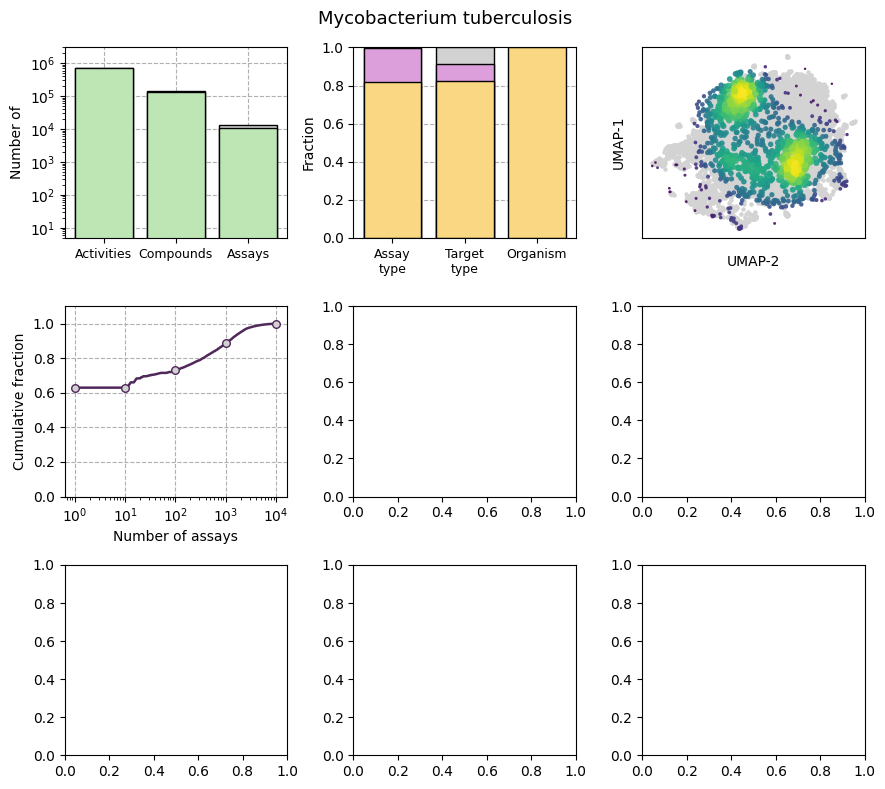

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(9, 8))

# Number of compounds, activities and assays
ax[0][0].bar([0, 0], [activities_raw, activities_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].bar([1, 1], [compounds_raw, compounds_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].bar([2, 2], [assays_raw, assays_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].grid(linestyle='--', zorder=-2)
ax[0][0].set_yscale('log')
ax[0][0].set_yticks([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])
ax[0][0].set_ylim([5, 3*10**6])
ax[0][0].set_xticks([0, 1, 2])
ax[0][0].set_xticklabels(['Activities', 'Compounds', 'Assays'], size=9)
ax[0][0].set_ylabel("Number of")

# Fraction assays
ax[0][1].bar([0, 0, 0], assay_type, zorder=2, color=['#D2D2D2', '#DC9FDC', '#FAD782'], ec='k')
ax[0][1].bar([1, 1, 1], target_type, zorder=2, color=['#D2D2D2', '#DC9FDC', '#FAD782'], ec='k')
ax[0][1].bar([2, 2], assay_organism, zorder=2, color=['#D2D2D2', '#FAD782'], ec='k')
ax[0][1].set_ylabel("Fraction")
ax[0][1].set_ylim([0, 1])
ax[0][1].grid(linestyle='--', zorder=-2)
ax[0][1].set_xticks([0, 1, 2])
ax[0][1].set_xticklabels(['Assay\ntype', 'Target\ntype', 'Organism'], size=9)

# 2D visualization
ax[0][2].scatter(ref_emb[:, 0], ref_emb[:, 1], s=5, c='lightgray')
sc = scatter_density(ax[0][2], X_pathogen[:, :2], size_min=3, size_max=30, cmap='viridis', alpha=0.9)
ax[0][2].set_yticks([])
ax[0][2].set_xticks([])
ax[0][2].set_ylabel("UMAP-1", labelpad=12)
ax[0][2].set_xlabel('UMAP-2', labelpad=12)

# Cumulative fraction chemical space
ax[1][0].set_ylim([0, 1.1])
ax[1][0].grid(linestyle='--', zorder=-2)
ax[1][0].plot([i+1 for i in range(len(CUM_PROP))], CUM_PROP, c="#50285A", lw=1.8)
x = [1, 10, 100, 1000, 10000]
y = [CUM_PROP[i-1] for i in x]
ax[1][0].scatter(x, y, zorder=2, ec="#50285A", s=30, c='#D2D2D2')
ax[1][0].set_xlabel("Number of assays")
ax[1][0].set_ylabel("Cumulative fraction")
ax[1][0].set_xscale('log')
ax[1][0].set_xticks([1, 10, 100, 1000, 10000])

plt.suptitle(pathogen, size=13)
plt.tight_layout()
plt.show()